In [152]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime 
from pandas import Series as Series

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import itertools
import scipy.stats as stats

In [2]:
# read input data

#1. training data set
daily_sales=pd.read_csv("sales_train.csv")
daily_sales.head(20)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [3]:
#2. supplemental info for shops

shops=pd.read_csv("shops.csv")
shops.set_index('shop_id', inplace=True)
shops.head()

,shop_name
shop_id,
0,"!Якутск Орджоникидзе, 56 фран"
1,"!Якутск ТЦ ""Центральный"" фран"
2,"Адыгея ТЦ ""Мега"""
3,"Балашиха ТРК ""Октябрь-Киномир"""
4,"Волжский ТЦ ""Волга Молл"""


In [4]:
#3. supplemental info for item_categories

cats=pd.read_csv("item_categories.csv")
cats.set_index('item_category_id', inplace=True)
cats.head()
#cats.describe()

,item_category_name
item_category_id,
0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2
2,Аксессуары - PS3
3,Аксессуары - PS4
4,Аксессуары - PSP


In [5]:
#4. additional info regarding items

items=pd.read_csv("items.csv")
items.set_index('item_id', inplace=True)
items.head()
#items.describe()

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


##### It is observed that the same category_id has multiple item_names listed

In [6]:
# read test data

test_file=pd.read_csv("test.csv")
test_file.set_index('ID', inplace=True)
test_file.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


## Data Preprocessing

In [7]:
# check for missingness
daily_sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [8]:
# column date_block_num is a consecutive number indicating the month-year from Jan2013-Oct2015
daily_sales['date_block_num'].unique()
# so, we have a total of 34 months of observations

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [9]:
# step 1. aggregate sales at monthly level for a particular shop_id
monthly_sales=daily_sales.groupby(['date_block_num','shop_id'], as_index=False).agg({'item_cnt_day':'sum'})
monthly_sales.head(10)

,date_block_num,shop_id,item_cnt_day
0,0,0,5578.0
1,0,1,2947.0
2,0,2,1146.0
3,0,3,767.0
4,0,4,2114.0
5,0,6,3686.0
6,0,7,2495.0
7,0,8,1463.0
8,0,10,935.0
9,0,12,842.0


In [180]:
#monthly_sales.sort_values(by='date_block_num', ascending=False)

In [10]:
monthly_sales.shape

(1586, 3)

In [11]:
print(monthly_sales.dtypes)

date_block_num      int64
shop_id             int64
item_cnt_day      float64
dtype: object


In [16]:
# step 2: let's focus on a single series- plot the monthly sales for any shop id (for e.g. ids 25 or 31)
monthly_sales_31=monthly_sales.loc[(monthly_sales['shop_id']==31)]
monthly_sales_31.set_index('date_block_num',inplace=True)
monthly_sales_31.rename(columns={'item_cnt_day':'monthly_sales'}, inplace=True)
monthly_sales_31.head(50)

,shop_id,monthly_sales
date_block_num,,
0,31,10173.0
1,31,11160.0
2,31,12670.0
3,31,9621.0
4,31,9423.0
5,31,10072.0
6,31,9500.0
7,31,9882.0
8,31,11204.0


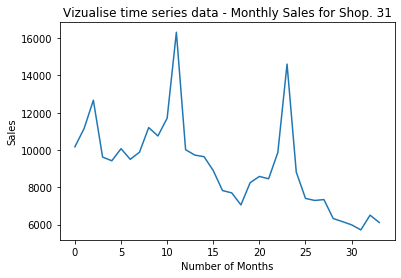

In [20]:
# step 3: plot the univariate time series data
plt.plot(monthly_sales_31['monthly_sales'], data=monthly_sales_31)
plt.title("Vizualise time series data - Monthly Sales for Shop. 31")
plt.xlabel("Number of Months")
plt.ylabel("Sales")
plt.show()

#### Observations: The data displays difference in trend, mean, and appears to be seasonal as well.

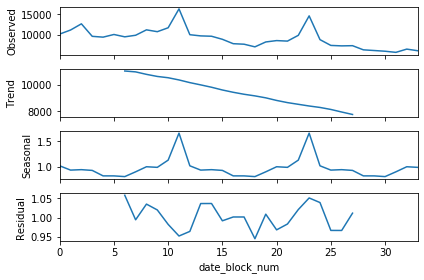

In [24]:
# step 4: decompose the series into trend, seasonality and noise

result_m=sm.tsa.seasonal_decompose(monthly_sales_31['monthly_sales'], freq=12, model='multiplicative')
fig=result_m.plot() 
plt.show()

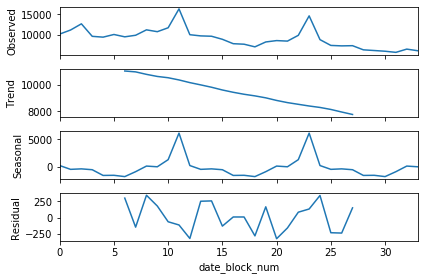

In [25]:
result_ad=sm.tsa.seasonal_decompose(monthly_sales_31['monthly_sales'], freq=12, model='additive')
fig=result_ad.plot() 
plt.show()

#### Since the seasonal components seem dependent on trend, we choose an additive model for decomposition. Further, an additive model is easier for computation and understanding. 

### (Weak) Stationarity

#### 1. constant mean
#### 2. constant finite variance
#### 3. covariance between two datapoints depends only on the lag 'k between them

In [220]:
# ADF test
# Null hypothesis: there is a unit root and hence, series is homogenous non- stationary

# When we assume only constant
X=monthly_sales_31['monthly_sales']
results_st=sm.tsa.stattools.adfuller(X, maxlag=6, regression='c', autolag='AIC')
print('ADF Statistic: %f' % results_st[0])
print('p-value: %f' % results_st[1])
print('Critical Values:')
for key, value in results_st[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.560753
p-value: 0.101383
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


#### We fail to reject the null at 5% l.o.s, thus, the data is non-stationary

In [35]:
# When we assume a constant and trend
results_st=sm.tsa.stattools.adfuller(X, maxlag=6, regression='ct', autolag='AIC')
print('ADF Statistic: %f' % results_st[0])
print('p-value: %f' % results_st[1])
print('Critical Values:')
for key, value in results_st[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.786549
p-value: 0.017254
Critical Values:
	1%: -4.263
	5%: -3.553
	10%: -3.210


#### Assuming a non-zero constant and trend, we reject the null hypothesis of non-stationarity at 5%. Hence, data is stationary.

### KPSS tests:

In [41]:
# KPSS test
# Null hypothesis: series is level stationary

results_st=sm.tsa.stattools.kpss(X, regression='c')
print('KPSS Statistic: %f' % results_st[0])
print('p-value: %f' % results_st[1])
print('Critical Values:')
for key, value in results_st[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.424835
p-value: 0.066451
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


#### At 5% level of significance, we observe that the data is level stationary.

In [42]:
# KPSS test
# Null hypothesis: series is trend stationary

results_st=sm.tsa.stattools.kpss(X, regression='ct')
print('KPSS Statistic: %f' % results_st[0])
print('p-value: %f' % results_st[1])
print('Critical Values:')
for key, value in results_st[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.193131
p-value: 0.018576
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


#### At 5% level of significance, we reject the null hypothesis and hence, the data is trend non-stationary.


#### Let's treat the data for trend non-stationarity by using first order differencing. Before differencing, let's also look at the ACF, PACF graphs.

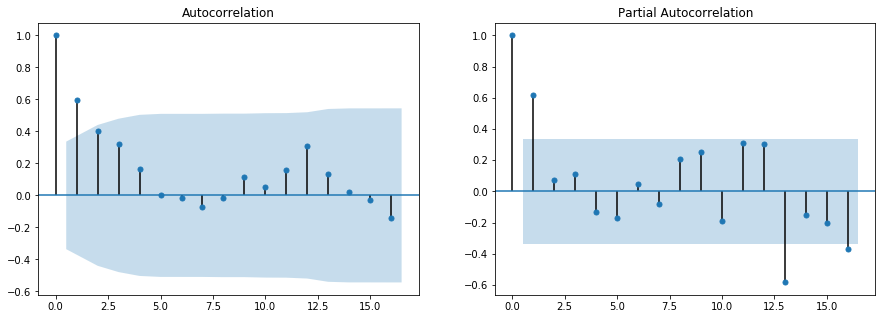

In [93]:
fig, ax=plt.subplots(1,2, figsize=(15,5))

acf_plot=plot_acf(X, alpha=0.05, ax=ax[0])
pacf_plot=plot_pacf(X,alpha=0.05, ax=ax[1])
plt.show()

#### The ACF plots indicates exponential decay with cut-off at lag 1 (q=1). PACF cuts-off at lag 1 (p=1).The above indicates a ARMA(1,1) model. 

### First Order Differencing

In [65]:
# function for creating a differenced series
def difference(ts, interval=1):
    diff=list()
    for i in range(interval, len(ts)):
        value=ts[i]-ts[i-interval]
        diff.append(value)
    return Series(diff)

# function for converting the differenced series back into original form
def inverse_difference(last_obs, value):
    return value + last_obs

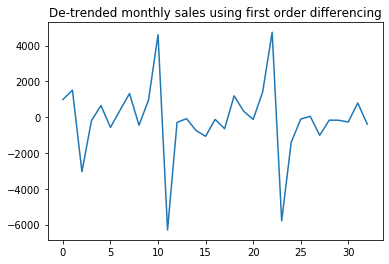

In [68]:
# FOD for monthly sales
diff_X=difference(X)
plt.plot(diff_X)
plt.title("De-trended monthly sales using first order differencing")
plt.show()

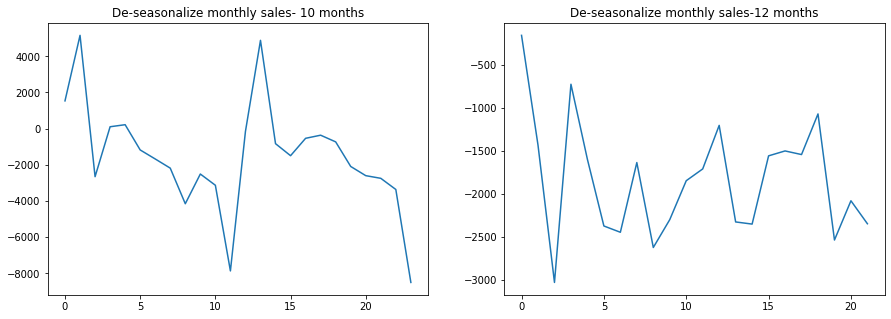

In [79]:
# there is a definite seasonal nature to the data
diff_X_10=difference(X,10)
diff_X_12=difference(X,12)

fig, ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(diff_X_10)
ax[0].set_title("De-seasonalize monthly sales- 10 months")
ax[1].plot(diff_X_12)
ax[1].set_title("De-seasonalize monthly sales-12 months")
plt.show()


#### Seasonality over 12 months is considered for de-seasonalizing

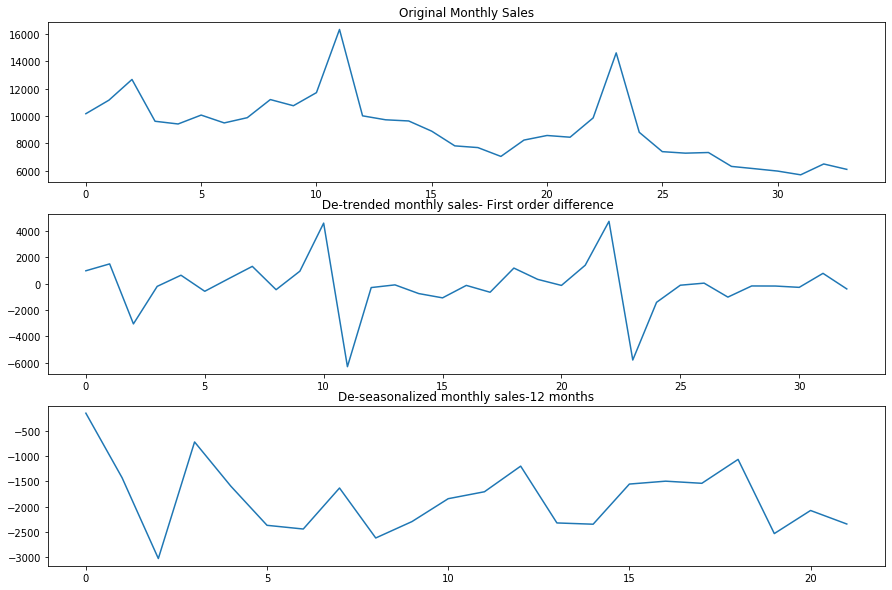

In [83]:
# De-trended and de-seasonalized monthly sales are shown below:

fig, ax=plt.subplots(3,1,figsize=(15,10))

ax[0].plot(X)
ax[0].set_title("Original Monthly Sales")
ax[1].plot(diff_X)

ax[1].set_title(" De-trended monthly sales- First order difference")
ax[2].plot(diff_X_12)
ax[2].set_title("De-seasonalized monthly sales-12 months")
plt.show()

In [84]:
# check for stationarity

#ADF, regression=drift
results_st=sm.tsa.stattools.adfuller(diff_X_12, maxlag=6, regression='c', autolag='AIC')
print('ADF Statistic: %f' % results_st[0])
print('p-value: %f' % results_st[1])
print('Critical Values:')
for key, value in results_st[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.408361
p-value: 0.000003
Critical Values:
	1%: -3.788
	5%: -3.013
	10%: -2.646


In [86]:
#ADF, regression=trend+drift
results_st=sm.tsa.stattools.adfuller(diff_X_12, maxlag=6, regression='ct', autolag='AIC')
print('ADF Statistic: %f' % results_st[0])
print('p-value: %f' % results_st[1])
print('Critical Values:')
for key, value in results_st[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.210603
p-value: 0.000084
Critical Values:
	1%: -4.469
	5%: -3.645
	10%: -3.261


### ADF test results: The null hypothesis is rejected at 5% level of significance. Thus, the treated series is stationary.

In [89]:
# KPSS test
# Null hypothesis: series is level stationary

results_st=sm.tsa.stattools.kpss(diff_X_12, regression='c')
print('KPSS Statistic: %f' % results_st[0])
print('p-value: %f' % results_st[1])
print('Critical Values:')
for key, value in results_st[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.259349
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [91]:
# KPSS test
# Null hypothesis: series is trend stationary

results_st=sm.tsa.stattools.kpss(diff_X_12, regression='ct')
print('KPSS Statistic: %f' % results_st[0])
print('p-value: %f' % results_st[1])
print('Critical Values:')
for key, value in results_st[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.154306
p-value: 0.043078
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


### KPSS test results: At 5% level, the treated series is level stationary however, we fail to reject the hypothesis that it is trend stationary.

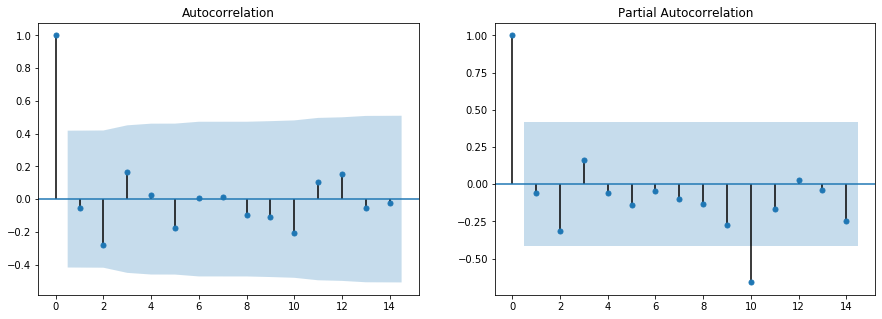

In [94]:
# ACF, PACF plots:
fig, ax=plt.subplots(1,2, figsize=(15,5))

acf_plot=plot_acf(diff_X_12, alpha=0.05, ax=ax[0])
pacf_plot=plot_pacf(diff_X_12,alpha=0.05, ax=ax[1])
plt.show()

#### The above plots indicate ARIMA(0,1,0) for the original series


### Given the seasonal nature of the monthly sales, we apply SARIMA. 

In [100]:
# different combinations of p,d,q are tried 
p=d=q=range(0,2)
pdq=list(itertools.product(p,d,q))
seasonality=[(x[0],x[1],x[2],12) for x in pdq]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonality[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonality[2]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)


In [107]:
# The below performs a grid search to identify the best combination of parameters based on minimum AIC

values=list()
for para in pdq:
    for para_seas in seasonality:
        try:
            mod=sm.tsa.statespace.SARIMAX(X, order=para, seasonal_order=para_seas, enforce_stationarity=False, enforce_invertibility=False)

            results=mod.fit()
            values.append(results.aic)
            print("ARIMA {}x{}12- AIC:{}".format(para, para_seas, results.aic))
        except:
            continue


ARIMA (0, 0, 0)x(0, 0, 0, 12)12- AIC:699.5809860191692
ARIMA (0, 0, 0)x(0, 1, 0, 12)12- AIC:380.7859006231182
ARIMA (0, 0, 0)x(1, 0, 0, 12)12- AIC:354.8651641479604
ARIMA (0, 0, 0)x(1, 1, 0, 12)12- AIC:165.4897459392639
ARIMA (0, 0, 1)x(0, 0, 0, 12)12- AIC:658.2672355171732
ARIMA (0, 0, 1)x(0, 1, 0, 12)12- AIC:355.33037126604444
ARIMA (0, 0, 1)x(1, 0, 0, 12)12- AIC:350.2937500144994
ARIMA (0, 0, 1)x(1, 1, 0, 12)12- AIC:166.33841391591375
ARIMA (0, 1, 0)x(0, 0, 0, 12)12- AIC:582.6163384620003
ARIMA (0, 1, 0)x(0, 1, 0, 12)12- AIC:330.56832974322765
ARIMA (0, 1, 0)x(1, 0, 0, 12)12- AIC:345.6057084259274
ARIMA (0, 1, 0)x(1, 1, 0, 12)12- AIC:147.35197078359764
ARIMA (0, 1, 1)x(0, 0, 0, 12)12- AIC:562.4217915179441
ARIMA (0, 1, 1)x(0, 1, 0, 12)12- AIC:300.9589564308218
ARIMA (0, 1, 1)x(1, 0, 0, 12)12- AIC:347.1807273633833
ARIMA (0, 1, 1)x(1, 1, 0, 12)12- AIC:143.67688792256752
ARIMA (1, 0, 0)x(0, 0, 0, 12)12- AIC:601.1164998281372
ARIMA (1, 0, 0)x(0, 1, 0, 12)12- AIC:349.44288020670126
ARIM

In [113]:
# Minimum AIC is observed for 
Series(values).min()

130.06111559785776

### Given the above results, the best model for the monthly sales is SARIMAX: (1, 1, 1) x (1, 1, 0, 12)

In [131]:
# Final ARIMA model results

model=sm.tsa.statespace.SARIMAX(X, order=(1,1,1), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
results=model.fit()

print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      monthly_sales   No. Observations:                   34
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 -61.031
Date:                            Mon, 18 May 2020   AIC                            130.061
Time:                                    18:22:08   BIC                            130.379
Sample:                                         0   HQIC                           127.918
                                             - 34                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1123      0.433      0.259      0.795      -0.737       0.961
ma.L1         -1.0000      0.927   

### Residual Analysis

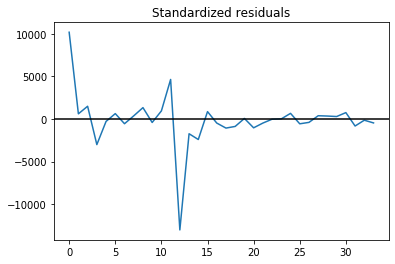

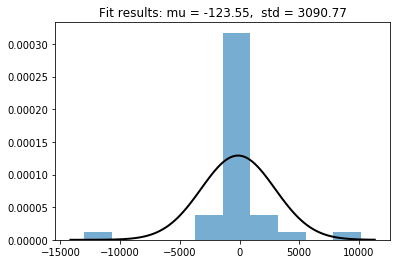

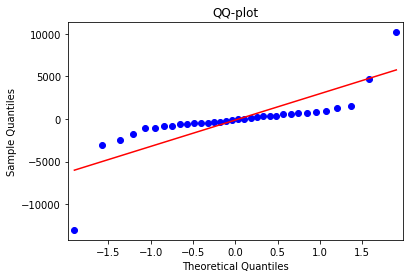

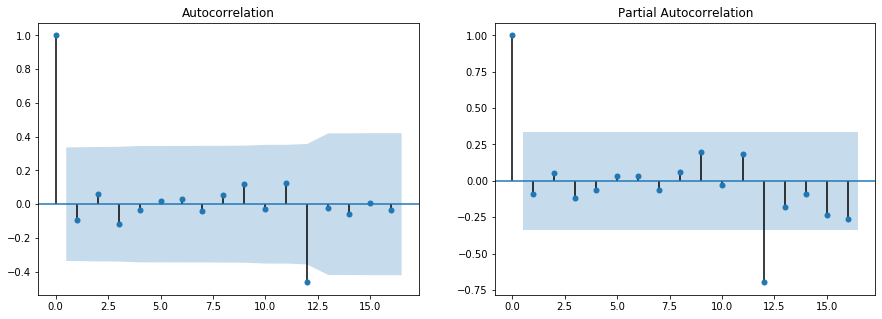

In [175]:
residuals=results.resid

#1. plot the standardized residuals

plt.plot(residuals)
plt.axhline(y=0, color='k', linestyle='-')
plt.title("Standardized residuals")
plt.show()

#2. plot the histogram

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(residuals)

plt.hist(residuals, density=True, alpha=0.6)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, stats.norm.pdf(x, mu, std), 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.show()

#3.QQ plot
sm.qqplot(residuals, line='s')
plt.title("QQ-plot")
plt.show()

#4, ACF, PACF plots
fig, ax=plt.subplots(1,2, figsize=(15,5))

acf_plot=plot_acf(residuals, alpha=0.05, ax=ax[0])
pacf_plot=plot_pacf(residuals,alpha=0.05, ax=ax[1])
plt.show()

In [185]:
# 5. Ljung-box test
resid_acorr=sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print('Q*: %2f' % resid_acorr[0])
print('pvalue: %2f' % resid_acorr[1])

Q*: 2.043302
pvalue: 0.995997


####  It is observed that the p-value is quite large and Q* (test statistic) is small hence, we do not reject the null hypothesis of the Ljung-box test. The model is deemed adequate.  
#### Based on above analysis, it is concluded that the residuals are white noise.

### Model Prediction

In [275]:
#let's add the dates back as index
X.index=pd.date_range(start='2013-01-01', end='2015-10-01', freq='MS')
Y=X.reset_index()
Y.rename(columns={'monthly_sales':'actual_sales'}, inplace=True)
Y.head()

,index,actual_sales
0,2013-01-01,10173.0
1,2013-02-01,11160.0
2,2013-03-01,12670.0
3,2013-04-01,9621.0
4,2013-05-01,9423.0


In [276]:
# predict the sales for the training months
Y['forecasted_sales']=round(results.predict(start=0, end=len(X)),2)
# we do not need to re-transform or invert the predicted value as the model was applied to the original series
Y.head(35)

,index,actual_sales,forecasted_sales
0,2013-01-01,10173.0,0.00
1,2013-02-01,11160.0,10553.78
2,2013-03-01,12670.0,11176.79
3,2013-04-01,9621.0,12625.65
4,2013-05-01,9423.0,9708.32
5,2013-06-01,10072.0,9441.57
6,2013-07-01,9500.0,10054.72
7,2013-08-01,9882.0,9515.10
8,2013-09-01,11204.0,9872.43
9,2013-10-01,10754.0,11162.03


#### Model Performance

In [277]:
#Validate forecasts

mse=((Y['actual_sales']-Y['forecasted_sales'])**2).mean()
print('Mean squared error: {}'.format(round(mse,2)))
print('Root mean squared error (RMSE): {}'.format(round(np.sqrt(mse),2)))

Mean squared error: 9568156.69
Root mean squared error (RMSE): 3093.24


In [278]:
#CERRPCT- abs(total actual- total predicted)/total actual

cerrpct=round((np.abs(Y['actual_sales'].sum()-Y['forecasted_sales'].sum())/Y['actual_sales'].sum())*100,2)
print('CERRPCT: {}%'.format(cerrpct))

CERRPCT: 1.35%


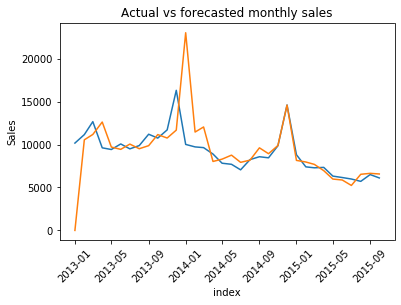

In [289]:
#Plot the actual vs predicted sales
sns.lineplot(Y['index'],Y['actual_sales'])
sns.lineplot(Y['index'],Y['forecasted_sales'])
plt.xticks(rotation=45)
plt.ylabel('Sales')
plt.title('Actual vs forecasted monthly sales')
plt.show()

#### Out of sample forecasts

In [295]:
# let's predict for the next 3 months- Nov'2015-Jan'2016 
forecasts=results.predict(start=len(X)-2, end=len(X)+2)
forecasts.head()

32     6648.004456
33     6573.941447
34     7938.102294
35    12731.554385
36     6950.543108
dtype: float64

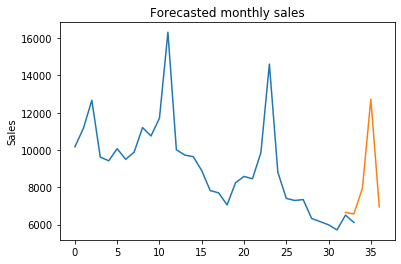

In [296]:
#Plot the forecasted sales
plt.plot(Y['actual_sales'])
plt.plot(forecasts)
plt.ylabel('Sales')
plt.title('Forecasted monthly sales')
plt.show()

### GARCH

In [ ]:
### Prophet and GARCH